In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import janssen as jns
from beartype.typing import Tuple

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
pixel_spacing_real = 50 / (10**9)
collimated_beam_waist = 10 / (10**3)
image_fov_x = 450 / (10**6)
image_fov_y = 450 / (10**6)
wavelength = 633 / (10**9)

In [5]:
num_pixels = image_fov_y / pixel_spacing_real
num_pixels

9000.0

In [6]:
xo = jnp.arange(start=-num_pixels / 2, stop=num_pixels / 2, step=1)
Xo, Yo = jnp.meshgrid(xo, xo)
Ro = ((Xo**2) + (Yo**2)) ** 0.5

In [7]:
def create_usaf_1951_array(size=1024):
    # Create a white (1.0) background
    chart = np.ones((size, size), dtype=np.float32)

    # Function to draw element (three bars)
    def draw_element(x, y, width, height, is_horizontal=True) -> None:
        # Convert from normalized coordinates to pixel coordinates
        x_pixel = int(x * size)
        y_pixel = int(y * size)
        width_pixel = max(1, int(width * size))
        height_pixel = max(1, int(height * size))

        if is_horizontal:
            # Draw three horizontal bars
            for i in range(3):
                y_offset = int(i * 2 * height_pixel)
                y1 = min(size - 1, y_pixel + y_offset)
                y2 = min(size - 1, y_pixel + y_offset + height_pixel)
                x2 = min(size - 1, x_pixel + width_pixel)
                chart[y1:y2, x_pixel:x2] = 0.0  # Black bars (0.0)
        else:
            # Draw three vertical bars
            for i in range(3):
                x_offset = int(i * 2 * width_pixel)
                x1 = min(size - 1, x_pixel + x_offset)
                x2 = min(size - 1, x_pixel + x_offset + width_pixel)
                y2 = min(size - 1, y_pixel + height_pixel)
                chart[y_pixel:y2, x1:x2] = 0.0  # Black bars (0.0)

    # USAF 1951 elements are organized into groups
    # Each group has 6 elements (numbered 1-6)
    # Each element has a horizontal and vertical set of 3 bars

    # Set initial parameters
    min_group = -2  # Starting with group -2
    max_group = 7  # Ending with group 7

    # Scale factors
    base_size = 0.15
    scale_factor = 2 ** (-1 / 6)  # Size reduction for each element

    for group in range(min_group, max_group + 1):
        # Calculate group position
        group_x = 0.12 + (group - min_group) * 0.12
        group_y = 0.8

        for element in range(1, 7):
            # Calculate element size based on group and element number
            size_multiplier = 2 ** (-group) * (scale_factor ** (element - 1))
            element_width = base_size * size_multiplier
            element_height = element_width / 5

            # Calculate element position offset within group
            element_y_offset = -0.08 * element

            # Draw horizontal element (on the left side)
            h_x = group_x - 0.05
            h_y = group_y + element_y_offset
            draw_element(
                h_x, h_y, element_width, element_height, is_horizontal=True
            )

            # Draw vertical element (on the right side)
            v_x = group_x + 0.01
            v_y = group_y + element_y_offset
            draw_element(
                v_x, v_y, element_height, element_width, is_horizontal=False
            )

    return chart


# Generate the chart as a numpy array
usaf_chart = create_usaf_1951_array(size=1024)

# Optional: save as image file
# import matplotlib.pyplot as plt
# plt.imsave('usaf_1951_chart.png', usaf_chart, cmap='gray')

# Optional: if you want to use the array directly
# print(usaf_chart.shape)  # Should be (size, size)

In [8]:
def generate_spiral_image(shape: Tuple[int, int]):
    H, W = shape

    # Create coordinate grids
    y, x = jnp.mgrid[0:H, 0:W]

    # Center the coordinates
    center_y, center_x = H // 2, W // 2
    y = y - center_y
    x = x - center_x

    # Convert to polar coordinates
    r = jnp.sqrt(x**2 + y**2)
    theta = jnp.arctan2(y, x)

    # Adjust theta to be in [0, 2π]
    theta = jnp.where(theta < 0, theta + 2 * jnp.pi, theta)

    # Golden ratio
    phi = (1 + jnp.sqrt(5)) / 2

    # Calculate the Fibonacci spiral
    # The Fibonacci spiral follows r = a * phi^(2*θ/π)
    # We'll normalize based on the image dimensions
    max_dim = max(H, W)
    a = max_dim / (4 * phi ** (4))  # Scaling factor

    # Calculate the ideal radius at each point
    ideal_r = a * phi ** (2 * theta / jnp.pi)

    # Create the spiral by measuring how close each point is to the ideal spiral
    # We'll use a smooth transition function for the spiral
    width = max_dim / 30  # Width of the spiral line
    spiral = jnp.exp(-((r - ideal_r) ** 2) / (2 * width**2))

    # Normalize to [0, 1]
    return spiral / jnp.max(spiral)

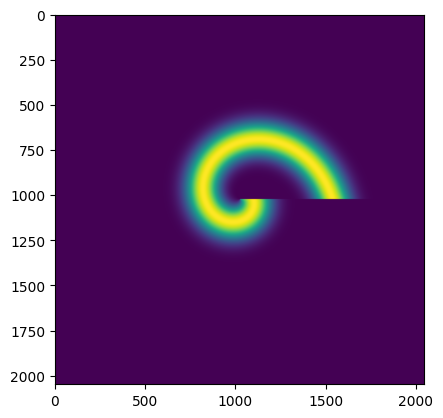

In [9]:
# starting_object = jnp.ones(shape=(2048, 2048), dtype=jnp.complex128)
starting_object = (generate_spiral_image(shape=(2048, 2048))).astype(
    jnp.complex128
)
plt.imshow(jnp.abs(starting_object))

In [11]:
object_dx = pixel_spacing_real
z0 = 0.0
starting_wave = jns.utils.make_optical_wavefront(
    starting_object, wavelength, object_dx, z0
)

In [12]:
after_aperture = jns.simul.circular_aperture(starting_wave, 1000 / (10**6))

In [13]:
after_aperture

OpticalWavefront(field=Array([[9.37028155e-68+0.j, 1.13475660e-67+0.j, 1.37393843e-67+0.j, ...,
        1.75099601e-51+0.j, 1.51510627e-51+0.j, 1.31076121e-51+0.j],
       [1.11323103e-67+0.j, 1.34811481e-67+0.j, 1.63223590e-67+0.j, ...,
        2.07956923e-51+0.j, 1.79947088e-51+0.j, 1.55682145e-51+0.j],
       [1.32231257e-67+0.j, 1.60127971e-67+0.j, 1.93871842e-67+0.j, ...,
        2.46933318e-51+0.j, 2.13680379e-51+0.j, 1.84872425e-51+0.j],
       ...,
       [1.56487121e-78+0.j, 1.89208118e-78+0.j, 2.28724864e-78+0.j, ...,
        1.66096680e-85+0.j, 1.34784166e-85+0.j, 1.09352018e-85+0.j],
       [1.27829157e-78+0.j, 1.54559752e-78+0.j, 1.86842362e-78+0.j, ...,
        1.35901058e-85+0.j, 1.10280176e-85+0.j, 8.94709525e-86+0.j],
       [1.04398213e-78+0.j, 1.26230665e-78+0.j, 1.52598101e-78+0.j, ...,
        1.11171885e-85+0.j, 9.02124063e-86+0.j, 7.31892957e-86+0.j]],      dtype=complex128), wavelength=Array(6.33e-07, dtype=float64), dx=Array(5.e-08, dtype=float64), z_position=A

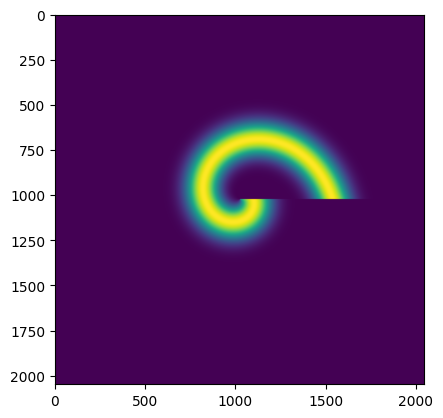

In [14]:
plt.imshow(jnp.abs(after_aperture.field))

In [17]:
distance = 110 / 1000
prop_to_detector_fraun = jns.lenses.fraunhofer_prop(after_aperture, distance)
prop_to_detector_fresn = jns.lenses.fresnel_prop(after_aperture, distance)
prop_to_detector_aspec = jns.lenses.angular_spectrum_prop(
    after_aperture, distance
)

detector_image_fraun = jnp.abs(prop_to_detector_fraun.field) ** 2
detector_image_fresn = jnp.abs(prop_to_detector_fresn.field) ** 2
detector_image_aspec = jnp.abs(prop_to_detector_aspec.field) ** 2

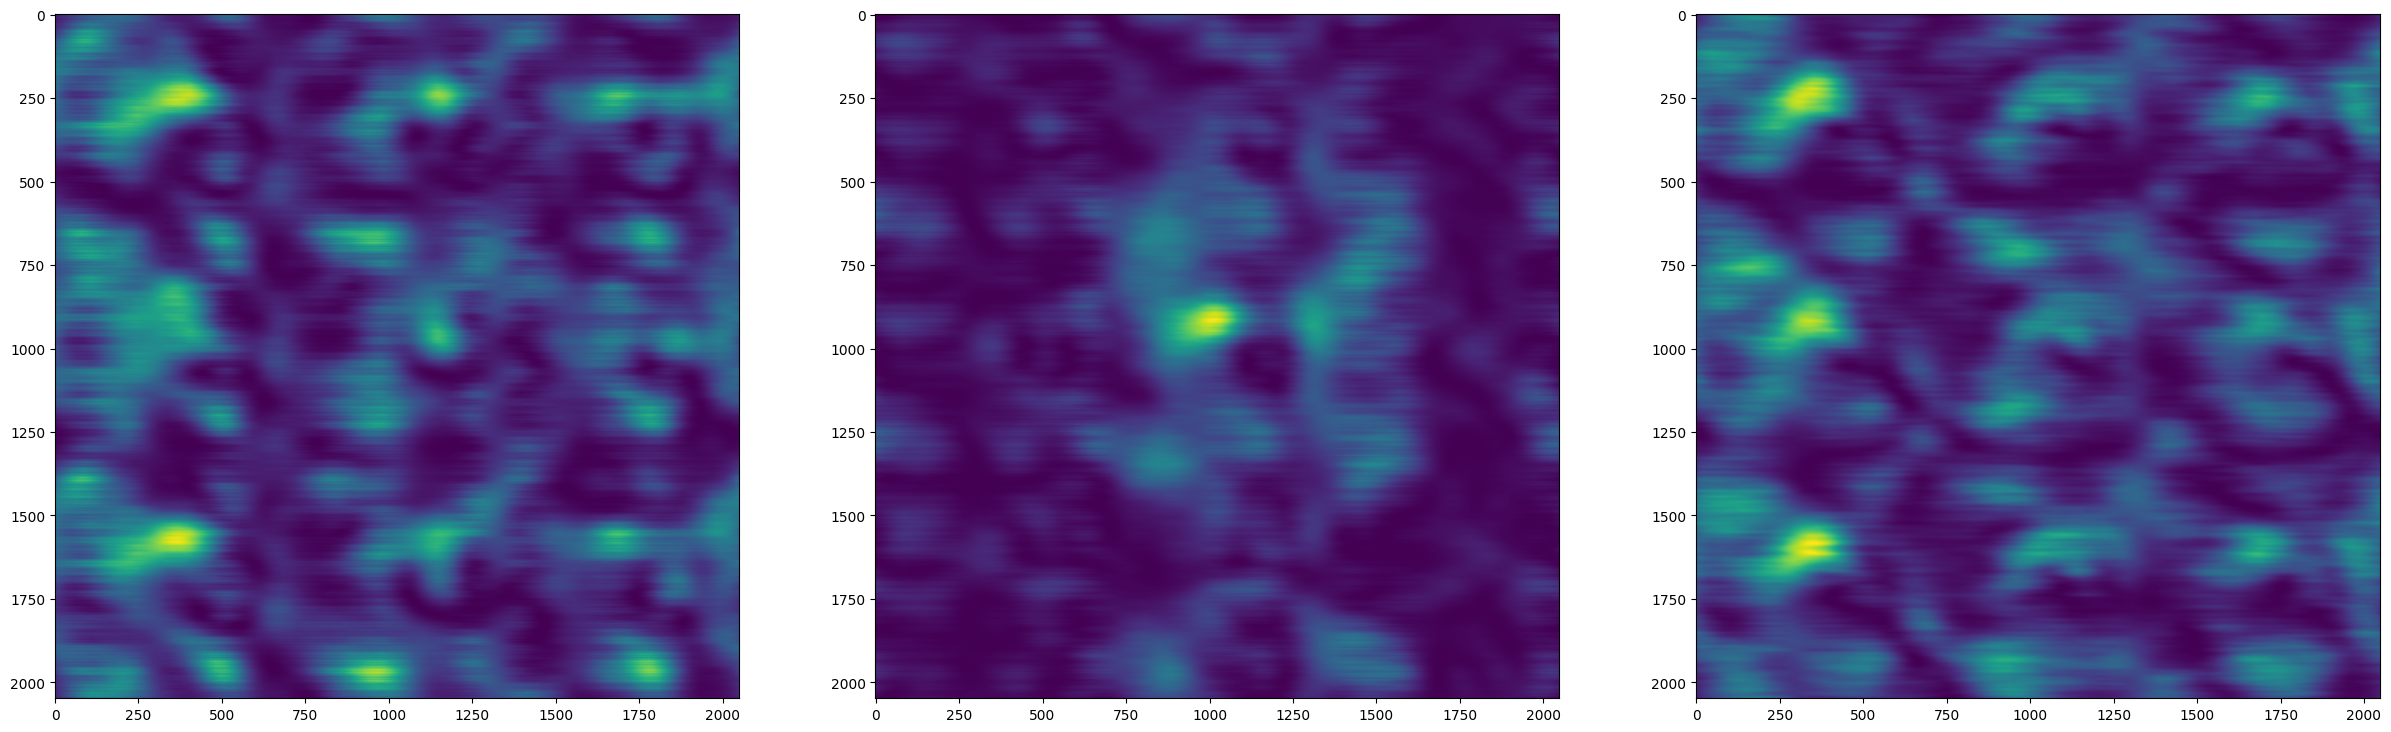

In [18]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(detector_image_fraun)
plt.subplot(1, 3, 2)
plt.imshow(detector_image_fresn)
plt.subplot(1, 3, 3)
plt.imshow(detector_image_aspec)

In [20]:
def single_diffractogram(initial_sample, zoom_factor, aperture_size, distance):
    zoomed_wave = jns.lenses.optical_zoom(initial_sample, zoom_factor)
    aperture_wavefront = jns.simul.circular_aperture(
        zoomed_wave, aperture_size
    )
    at_detector = jns.lenses.fraunhofer_prop(aperture_wavefront, distance)
    detector_image = jns.simul.field_intensity(at_detector.field)
    return jns.utils.make_diffractogram(
        detector_image, at_detector.wavelength, at_detector.dx
    )

In [21]:
%timeit single_diffractogram(starting_wave, 10.0, 1/1000, 110/1000)

434 ms ± 4.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


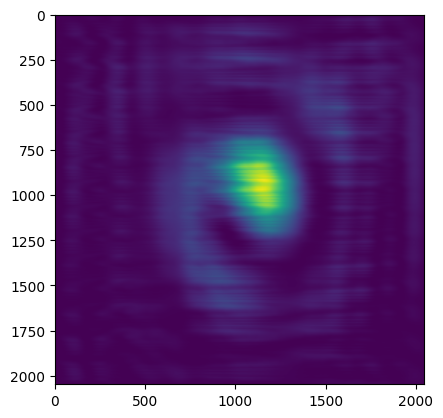

In [22]:
plt.imshow(
    single_diffractogram(starting_wave, 10.0, 1 / 1000, 110 / 1000).image
)

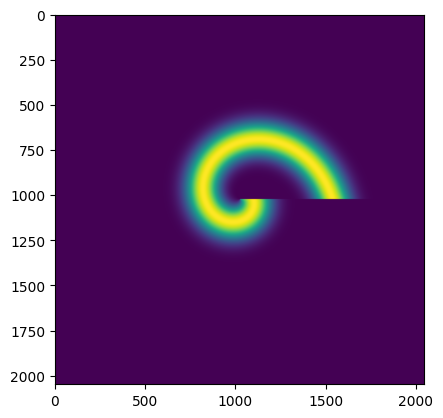

In [23]:
plt.imshow(
    jnp.abs(
        jns.simul.circular_aperture(
            jns.lenses.optical_zoom(starting_wave, 10), 1 / 1000
        ).field
    )
)